In [45]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [5]:
import os
import cv2
import time
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# data augmentation
import albumentations as A

# pretrained models
import torchvision
from torchvision import models, transforms

In [6]:
data_path = '../data/sourse2/Face_Mask_Dataset'

rows = []
for dataset in os.listdir(data_path):
    for label in os.listdir(data_path + f'/{dataset}'):
        for image in os.listdir(data_path + f'/{dataset}' + f'/{label}'):
            row = dict()
            row['image_file'] = image
            row['label'] = label
            row['dataset'] = dataset
        
            # a bit redudant, could build from other data in __getitem__ if wanted
            row['image_path'] = data_path + f'/{dataset}' + f'/{label}'
            rows.append(row)
        
df = pd.DataFrame(rows)
print(len(df))
df.head()

11792


,image_file,label,dataset,image_path
0,2734.png,WithoutMask,Test,../data/sourse2/Face_Mask_Dataset/Test/Without...
1,4345.png,WithoutMask,Test,../data/sourse2/Face_Mask_Dataset/Test/Without...
2,4423.png,WithoutMask,Test,../data/sourse2/Face_Mask_Dataset/Test/Without...
3,2052.png,WithoutMask,Test,../data/sourse2/Face_Mask_Dataset/Test/Without...
4,3364.png,WithoutMask,Test,../data/sourse2/Face_Mask_Dataset/Test/Without...


In [38]:
df.to_csv('face_pic.csv',index = None)

In [8]:
# training and validation data
df_train = df[df['dataset'] == 'Train'].reset_index(drop=True)
df_val = df[df['dataset'] == 'Validation'].reset_index(drop=True)
df_test = df[df['dataset'] == 'Test'].reset_index(drop=True)
len(df_train), len(df_val),len(df_test)

(10000, 800, 992)

In [9]:
def resize_img(path, size):
    img = cv2.imread(path)
    
    start = time.time()
    img = cv2.resize(img, size)
    end = time.time()
    
    cv2.imwrite(path, img)
    return end - start

# resize all of the images to 256x256
total_time_resize = 0.0
for idx in tqdm(range(len(df_train))):
    row = df_train.iloc[idx]
    image_path = row['image_path']
    fname = row['image_file']
    path = image_path+'/'+fname
    
    total_time_resize += resize_img(path, (256, 256))
    
for idx in tqdm(range(len(df_val))):
    row = df_train.iloc[idx]
    image_path = row['image_path']
    fname = row['image_file']
    path = image_path+'/'+fname
    
    total_time_resize += resize_img(path, (256, 256))

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

WithMask


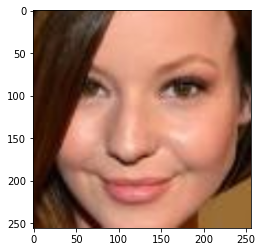

In [19]:
row = df_train.iloc[1000]
image_path = row['image_path']
fname = row['image_file']
path = image_path+'/'+fname
img = cv2.imread(path)
out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
plt.imshow(out_img)
print(label)

In [24]:
from albumentations.pytorch import ToTensorV2

# let's add an augmentation option
class FaceMaskDataset(Dataset):
    def __init__(self, df, augment=False):
        self.df = df
        self.augment = augment
        
        # label dictionary
        self.label_dict = {'WithoutMask':0, 'WithMask':1}
        
        # define the transformation
        if augment == True:
            self.transforms = A.Compose([
                # spatial transforms
                A.PadIfNeeded(min_height=256, min_width=256,p=1),
                A.RandomCrop(width=224, height=224),
                A.HorizontalFlip(p=.5),
                A.VerticalFlip(p=.5),
                A.Rotate(limit = 10, 
                         border_mode = cv2.BORDER_CONSTANT, 
                         value = 0.0, p = .75),
                
                # pixel-level transformation
                A.RandomBrightnessContrast(p=0.5),
                
                # we will normalize according to ImageNet since we will be using a pre-trained ResNet
                # this adjusts from [0,255] to [0,1]
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                
                # convert to a tensor and move color channels
                ToTensorV2()
            ])
        else:
            self.transforms = A.Compose([
                # training/valid images have same size
                A.PadIfNeeded(min_height=256, min_width=256,p=1),
                A.CenterCrop(width=224, height=224),
                
                # normalize
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                
                # convert to a tensor and move color channels
                ToTensorV2()
            ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # get ingredients for retrieving image
        image_path = row['image_path']
        fname = row['image_file']
        path = image_path+'/'+fname
        
        # read the img
        img = cv2.imread(path)
        
        # convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # transform the image
        # certain transformations expect the uint8 datatype
        transformed = self.transforms(image=img.astype(np.uint8))
        img = transformed['image']
        
        label = torch.tensor(self.label_dict[row['label']])
        
        return img, label

In [25]:
ds_train = FaceMaskDataset(df_train, augment=False)
dl_train = DataLoader(ds_train, batch_size = 32, shuffle=True)

ds_val = FaceMaskDataset(df_val)
dl_val = DataLoader(ds_val, batch_size = 32, shuffle=True)

torch.Size([3, 224, 224])
tensor(0)


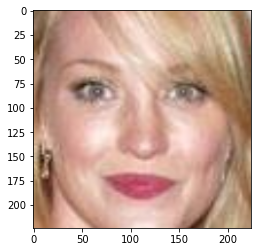

In [26]:
img, label = ds_train[105]
print(img.shape)

# restructure for plt
img = np.transpose(np.array(img), (1,2,0))

# reverse the normalization
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
for i in range(3):
    img[:,:,i] = (img[:,:,i] * std[i]) + mean[i]

plt.imshow(img)
print(label)

In [27]:
from MobileNetV2 import mobilenet_v2

net = mobilenet_v2(pretrained=True)

Downloading: "https://www.dropbox.com/s/47tyzpofuuyyv1b/mobilenetv2_1.0-f2a8633.pth.tar?dl=1" to /Users/huangyi/.cache/torch/hub/checkpoints/mobilenetv2_1.0-f2a8633.pth.tar


  0%|          | 0.00/13.5M [00:00<?, ?B/s]

In [28]:
net

MobileNetV2(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
       

In [29]:
for param in net.parameters():
    param.requires_grad = False

In [30]:
print(net.classifier)

Linear(in_features=1280, out_features=1000, bias=True)


In [31]:
net.classifier = nn.Linear(1280,2)

In [32]:
print(net.classifier)

Linear(in_features=1280, out_features=2, bias=True)


In [33]:
for param in net.classifier.parameters():
    print(param.requires_grad)

True
True


In [34]:
params_to_update = []

for param in net.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = optim.Adam(params_to_update, lr=0.001)

In [35]:
params_to_update

[Parameter containing:
 tensor([[ 0.0199,  0.0194, -0.0159,  ..., -0.0241, -0.0277, -0.0127],
         [ 0.0097,  0.0140, -0.0191,  ...,  0.0089, -0.0040,  0.0110]],
        requires_grad=True),
 Parameter containing:
 tensor([0.0020, 0.0164], requires_grad=True)]

In [36]:
def one_pass(model, dataloader, optimizer, lossFun, backwards=True, print_loss=False):
    
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    for x, y in tqdm(dataloader):
        
        y_pred = model(x)
        loss = lossFun(y_pred, y)
        total_loss += loss.item()
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss

def one_pass_acc(model, dataloader, num_points):
    model.eval()
    total_incorrect = 0
    
    softmax = nn.LogSoftmax(dim=1)
    
    for x, y in dataloader:
        y_pred = softmax(model(x))
        y_pred = torch.argmax(y_pred, dim=1)
        
        total_incorrect += torch.count_nonzero(y - y_pred).item()
        
    percent_wrong = total_incorrect / num_points
    return 1 - percent_wrong

In [37]:
from tqdm.notebook import tqdm

lossFun = nn.CrossEntropyLoss()

num_epochs = 5
train_losses = []
valid_losses = []

for epoch in tqdm(range(num_epochs)):
    print('Epoch: ', epoch)
    
    train_loss = one_pass(net, dl_train, optimizer, lossFun)
    train_losses.append(train_loss)
    print('Train loss: ', train_loss)
    
    valid_loss = one_pass(net, dl_val, optimizer, lossFun, backwards=False)
    valid_losses.append(valid_loss)
    print('Valid loss: ', valid_loss)
    
    train_acc = one_pass_acc(net, dl_train, len(ds_train))
    valid_acc = one_pass_acc(net, dl_val, len(ds_val))
    print('Train Acc: ', train_acc)
    print('Valid Acc: ', valid_acc)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  0


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss:  0.11882997157510382


  0%|          | 0/25 [00:00<?, ?it/s]

Valid loss:  0.20370759785175324
Train Acc:  0.99
Valid Acc:  0.91625
Epoch:  1


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss:  0.05801811892860614


  0%|          | 0/25 [00:00<?, ?it/s]

Valid loss:  0.1237209016084671
Train Acc:  0.9939
Valid Acc:  0.955
Epoch:  2


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss:  0.048716984081495635


  0%|          | 0/25 [00:00<?, ?it/s]

Valid loss:  0.10613271355628967
Train Acc:  0.9935
Valid Acc:  0.96375
Epoch:  3


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss:  0.050096301227278366


  0%|          | 0/25 [00:00<?, ?it/s]

Valid loss:  0.11297222644090653
Train Acc:  0.9951
Valid Acc:  0.965
Epoch:  4


  0%|          | 0/313 [00:00<?, ?it/s]

Train loss:  0.032680711487662224


  0%|          | 0/25 [00:00<?, ?it/s]

Valid loss:  0.09585906136780978
Train Acc:  0.9947
Valid Acc:  0.9675


In [39]:
torch.save(net, 'MobileNetV2_mask')

In [42]:
ds_train[0][0].shape

torch.Size([3, 224, 224])

In [44]:
next(iter(dl_train))[0].shape

torch.Size([32, 3, 224, 224])

# Better Model

In [46]:
data_path = '../data/sourse2/Face_Mask_Dataset'

rows = []
for dataset in os.listdir(data_path):
    for label in os.listdir(data_path + f'/{dataset}'):
        for image in os.listdir(data_path + f'/{dataset}' + f'/{label}'):
            row = dict()
            row['image_file'] = image
            row['label'] = label
            row['dataset'] = dataset
        
            # a bit redudant, could build from other data in __getitem__ if wanted
            row['image_path'] = data_path + f'/{dataset}' + f'/{label}'
            row['sourse'] = 1
            rows.append(row)

data_path_2 = '../data/sourse3/Data'
for label in os.listdir(data_path_2):
    for image in os.listdir(data_path_2 + f'/{label}'):
        row = dict()
        row['image_file'] = image
        row['label'] = label
        row['dataset'] = 'None'

        # a bit redudant, could build from other data in __getitem__ if wanted
        row['image_path'] = data_path_2 + f'/{label}'
        row['sourse'] = 2
        rows.append(row)

df = pd.DataFrame(rows)
print(len(df))
df.head()

13168


,image_file,label,dataset,image_path,sourse
0,2734.png,WithoutMask,Test,../data/sourse2/Face_Mask_Dataset/Test/Without...,1
1,4345.png,WithoutMask,Test,../data/sourse2/Face_Mask_Dataset/Test/Without...,1
2,4423.png,WithoutMask,Test,../data/sourse2/Face_Mask_Dataset/Test/Without...,1
3,2052.png,WithoutMask,Test,../data/sourse2/Face_Mask_Dataset/Test/Without...,1
4,3364.png,WithoutMask,Test,../data/sourse2/Face_Mask_Dataset/Test/Without...,1


In [56]:
df.label.value_counts()

WithoutMask    6595
WithMask       6573
Name: label, dtype: int64

In [48]:
# test set for comparison
train_df,valid_df = train_test_split(df, test_size=0.2, random_state=42)

In [55]:
len(train_df),len(valid_df)

(10534, 2634)

In [49]:
from albumentations.pytorch import ToTensorV2

# let's add an augmentation option
class FaceMaskDataset(Dataset):
    def __init__(self, df, augment=False):
        self.df = df
        self.augment = augment
        
        # label dictionary
        self.label_dict = {'WithoutMask':0, 'WithMask':1}
        
        # define the transformation
        if augment == True:
            self.transforms = A.Compose([
                # spatial transforms
                A.PadIfNeeded(min_height=256, min_width=256,p=1),
                A.RandomCrop(width=224, height=224),
                A.HorizontalFlip(p=.5),
                A.VerticalFlip(p=.5),
                A.Rotate(limit = 10, 
                         border_mode = cv2.BORDER_CONSTANT, 
                         value = 0.0, p = .75),
                
                # pixel-level transformation
                A.RandomBrightnessContrast(p=0.5),
                
                # we will normalize according to ImageNet since we will be using a pre-trained ResNet
                # this adjusts from [0,255] to [0,1]
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                
                # convert to a tensor and move color channels
                ToTensorV2()
            ])
        else:
            self.transforms = A.Compose([
                # training/valid images have same size
                A.PadIfNeeded(min_height=256, min_width=256,p=1),
                A.CenterCrop(width=224, height=224),
                
                # normalize
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                
                # convert to a tensor and move color channels
                ToTensorV2()
            ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # get ingredients for retrieving image
        image_path = row['image_path']
        fname = row['image_file']
        path = image_path+'/'+fname
        
        # read the img
        img = cv2.imread(path)
        
        # convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # transform the image
        # certain transformations expect the uint8 datatype
        transformed = self.transforms(image=img.astype(np.uint8))
        img = transformed['image']
        
        label = torch.tensor(self.label_dict[row['label']])
        
        return img, label

In [50]:
ds_train = FaceMaskDataset(train_df, augment=False)
dl_train = DataLoader(ds_train, batch_size = 32, shuffle=True)

ds_val = FaceMaskDataset(valid_df)
dl_val = DataLoader(ds_val, batch_size = 32, shuffle=True)

In [53]:
net = mobilenet_v2(pretrained=True)
for param in net.parameters():
    param.requires_grad = False
net.classifier = nn.Linear(1280,2)
params_to_update = []

for param in net.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = optim.Adam(params_to_update, lr=0.001)

lossFun = nn.CrossEntropyLoss()

num_epochs = 30
train_losses = []
valid_losses = []
acc_train = []
acc_valid = []
best_acc_valid = 0

for epoch in tqdm(range(num_epochs)):
    print('Epoch: ', epoch)
    
    train_loss = one_pass(net, dl_train, optimizer, lossFun)
    train_losses.append(train_loss)
    print('Train loss: ', train_loss)
    
    valid_loss = one_pass(net, dl_val, optimizer, lossFun, backwards=False)
    valid_losses.append(valid_loss)
    print('Valid loss: ', valid_loss)
    
    train_acc = one_pass_acc(net, dl_train, len(ds_train))
    valid_acc = one_pass_acc(net, dl_val, len(ds_val))
    acc_train.append(train_acc)
    acc_valid.append(valid_acc)
    print('Train Acc: ', train_acc)
    print('Valid Acc: ', valid_acc)
    
    if valid_acc > best_acc_valid:
        print('Save model')
        torch.save(net, 'MobileNetV2_mask_fulldata')
        best_acc_valid = valid_acc

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch:  0


  0%|          | 0/330 [00:00<?, ?it/s]

Train loss:  0.11781336069671494


  0%|          | 0/83 [00:00<?, ?it/s]

Valid loss:  0.041572354038257195
Train Acc:  0.9887981773305488
Valid Acc:  0.9882308276385725
Save model
Epoch:  1


  0%|          | 0/330 [00:00<?, ?it/s]

Train loss:  0.06830067024001796


  0%|          | 0/83 [00:00<?, ?it/s]

Valid loss:  0.03218732569198382
Train Acc:  0.991171444845263
Valid Acc:  0.9905087319665907
Save model
Epoch:  2


  0%|          | 0/330 [00:00<?, ?it/s]

Train loss:  0.05844380133714753


  0%|          | 0/83 [00:00<?, ?it/s]

Valid loss:  0.028674286843490708
Train Acc:  0.9917410290487944
Valid Acc:  0.9901290812452543
Epoch:  3


  0%|          | 0/330 [00:00<?, ?it/s]

Train loss:  0.05079494981151639


  0%|          | 0/83 [00:00<?, ?it/s]

Valid loss:  0.024807075518239515
Train Acc:  0.9938295044617429
Valid Acc:  0.9912680334092635
Save model
Epoch:  4


  0%|          | 0/330 [00:00<?, ?it/s]

Train loss:  0.0538063977739181


  0%|          | 0/83 [00:00<?, ?it/s]

Valid loss:  0.0239875597587551
Train Acc:  0.9936396430605657
Valid Acc:  0.9931662870159453
Save model
Epoch:  5


  0%|          | 0/330 [00:00<?, ?it/s]

Train loss:  0.04137028147004347


  0%|          | 0/83 [00:00<?, ?it/s]

Valid loss:  0.031333028825549745
Train Acc:  0.9902221378393773
Valid Acc:  0.9889901290812453
Epoch:  6


  0%|          | 0/330 [00:00<?, ?it/s]

Train loss:  0.04174419456023977


  0%|          | 0/83 [00:00<?, ?it/s]

Valid loss:  0.024207481098956013
Train Acc:  0.9943041579646857
Valid Acc:  0.9905087319665907
Epoch:  7


  0%|          | 0/330 [00:00<?, ?it/s]

Train loss:  0.039961861816735826


  0%|          | 0/83 [00:00<?, ?it/s]

Valid loss:  0.021660191126880293
Train Acc:  0.9947788114676286
Valid Acc:  0.992786636294609
Epoch:  8


  0%|          | 0/330 [00:00<?, ?it/s]

Train loss:  0.04495859429801137


  0%|          | 0/83 [00:00<?, ?it/s]

Valid loss:  0.019434998959936875
Train Acc:  0.9955382570723372
Valid Acc:  0.9924069855732726
Epoch:  9


  0%|          | 0/330 [00:00<?, ?it/s]

Train loss:  0.04066079226957465


  0%|          | 0/83 [00:00<?, ?it/s]

Valid loss:  0.018200044075576925
Train Acc:  0.9951585342699829
Valid Acc:  0.9931662870159453
Epoch:  10


  0%|          | 0/330 [00:00<?, ?it/s]

Train loss:  0.04136058998798641


  0%|          | 0/83 [00:00<?, ?it/s]

Valid loss:  0.024447061474040903
Train Acc:  0.9932599202582115
Valid Acc:  0.9893697798025817
Epoch:  11


  0%|          | 0/330 [00:00<?, ?it/s]

Train loss:  0.041234267290212415


  0%|          | 0/83 [00:00<?, ?it/s]

Valid loss:  0.021990588280591125
Train Acc:  0.9958230491741029
Valid Acc:  0.9924069855732726
Epoch:  12


  0%|          | 0/330 [00:00<?, ?it/s]

Train loss:  0.04346982260723246


  0%|          | 0/83 [00:00<?, ?it/s]

Valid loss:  0.016271811674337788
Train Acc:  0.9963926333776343
Valid Acc:  0.9946848899012908
Save model
Epoch:  13


  0%|          | 0/330 [00:00<?, ?it/s]

Train loss:  0.050209466568423636


  0%|          | 0/83 [00:00<?, ?it/s]

Valid loss:  0.03225821459978673
Train Acc:  0.9914562369470287
Valid Acc:  0.9878511769172361
Epoch:  14


  0%|          | 0/330 [00:00<?, ?it/s]

Train loss:  0.038764646981673485


  0%|          | 0/83 [00:00<?, ?it/s]

Valid loss:  0.020601961613739336
Train Acc:  0.9950636035693944
Valid Acc:  0.9931662870159453
Epoch:  15


  0%|          | 0/330 [00:00<?, ?it/s]

Train loss:  0.04297932063500136


  0%|          | 0/83 [00:00<?, ?it/s]

Valid loss:  0.0357539012561081
Train Acc:  0.9888931080311373
Valid Acc:  0.9886104783599089
Epoch:  16


  0%|          | 0/330 [00:00<?, ?it/s]

Train loss:  0.04802737836540804


  0%|          | 0/83 [00:00<?, ?it/s]

Valid loss:  0.01826665175925093
Train Acc:  0.9969622175811658
Valid Acc:  0.9935459377372817
Epoch:  17


  0%|          | 0/330 [00:00<?, ?it/s]

Train loss:  0.03749845018786745


  0%|          | 0/83 [00:00<?, ?it/s]

Valid loss:  0.021750568237270687
Train Acc:  0.9944940193658629
Valid Acc:  0.9920273348519362
Epoch:  18


  0%|          | 0/330 [00:00<?, ?it/s]

Train loss:  0.04185940022589145


  0%|          | 0/83 [00:00<?, ?it/s]

Valid loss:  0.018505667959036957
Train Acc:  0.9965824947788114
Valid Acc:  0.9935459377372817
Epoch:  19


  0%|          | 0/330 [00:00<?, ?it/s]

Train loss:  0.034978730836794994


  0%|          | 0/83 [00:00<?, ?it/s]

Valid loss:  0.023915635839845222
Train Acc:  0.9940193658629201
Valid Acc:  0.9920273348519362
Epoch:  20


  0%|          | 0/330 [00:00<?, ?it/s]

Train loss:  0.0294255896669876


  0%|          | 0/83 [00:00<?, ?it/s]

Valid loss:  0.016277715937565475
Train Acc:  0.9963926333776343
Valid Acc:  0.9939255884586181
Epoch:  21


  0%|          | 0/330 [00:00<?, ?it/s]

Train loss:  0.0382217329051469


  0%|          | 0/83 [00:00<?, ?it/s]

Valid loss:  0.02321401420322875
Train Acc:  0.9944940193658629
Valid Acc:  0.9901290812452543
Epoch:  22


  0%|          | 0/330 [00:00<?, ?it/s]

Train loss:  0.03052636988666729


  0%|          | 0/83 [00:00<?, ?it/s]

Valid loss:  0.021773064807260756
Train Acc:  0.9958230491741029
Valid Acc:  0.9916476841305999
Epoch:  23


  0%|          | 0/330 [00:00<?, ?it/s]

Train loss:  0.031976690716339476


  0%|          | 0/83 [00:00<?, ?it/s]

Valid loss:  0.018086685165352643
Train Acc:  0.9970571482817543
Valid Acc:  0.992786636294609
Epoch:  24


  0%|          | 0/330 [00:00<?, ?it/s]

Train loss:  0.02761624074302028


  0%|          | 0/83 [00:00<?, ?it/s]

Valid loss:  0.015515647645365076
Train Acc:  0.99734194038352
Valid Acc:  0.9935459377372817
Epoch:  25


  0%|          | 0/330 [00:00<?, ?it/s]

Train loss:  0.03211409797372515


  0%|          | 0/83 [00:00<?, ?it/s]

Valid loss:  0.03100069966402146
Train Acc:  0.9908866527434973
Valid Acc:  0.9874715261958997
Epoch:  26


  0%|          | 0/330 [00:00<?, ?it/s]

Train loss:  0.045729223140546255


  0%|          | 0/83 [00:00<?, ?it/s]

Valid loss:  0.017821544470827948
Train Acc:  0.9977216631858743
Valid Acc:  0.9931662870159453
Epoch:  27


  0%|          | 0/330 [00:00<?, ?it/s]

Train loss:  0.031150661832251705


  0%|          | 0/83 [00:00<?, ?it/s]

Valid loss:  0.02193708696578109
Train Acc:  0.9956331877729258
Valid Acc:  0.9920273348519362
Epoch:  28


  0%|          | 0/330 [00:00<?, ?it/s]

Train loss:  0.026566639463117374


  0%|          | 0/83 [00:00<?, ?it/s]

Valid loss:  0.02662366534857127
Train Acc:  0.9943990886652744
Valid Acc:  0.9878511769172361
Epoch:  29


  0%|          | 0/330 [00:00<?, ?it/s]

Train loss:  0.03534009436036534


  0%|          | 0/83 [00:00<?, ?it/s]

Valid loss:  0.017381543551584992
Train Acc:  0.99734194038352
Valid Acc:  0.992786636294609


In [54]:
1

1